In [1]:
import torch
from torch.autograd import Variable
import random as rd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

###### Dataset Trump Tweets

On utilise l'ensemble des tweets postés par Donald Trump.

In [2]:
data = pd.read_csv("trump.csv", dtype=str, delimiter=",", usecols=[2])
data.sample(5)

,Tweet_Text
4444,"""@jasthompcountry: @realDonaldTrump @DanScavin..."
7303,"""@koltonbittner: .@realDonaldTrump makes me pr..."
1721,"Thank you Dallas, Texas!\nhttps://t.co/ui9tSfM..."
1266,The dishonest media didnt mention that Bernie ...
5160,"""@antSTACKSgrieco: @realDonaldTrump you were g..."


On utilise les fonctions ord et chr pour facilement convertir les caractères en valeurs numériques, et on crée les ensembles d'apprentissage et de test.

In [3]:
BATCH_SIZE = 1
#TWEET_SIZE = 280
VOCAB_SIZE = 128
#FINAL_CHAR = 160 # espace insécable
FINAL_CHAR = VOCAB_SIZE
 
BLANK_OHOT = torch.FloatTensor(BATCH_SIZE, VOCAB_SIZE+1).zero_()
 
def encode(row):
   
    # Conversion en int, et suppression des cractères spéciaux (emojis, bugs, etc)
    #[:TWEET_SIZE-1] et limitation en taille (aberrations csv)
   
    # Normalisation longueur tweets
    '''
    for i in range(len(l), TWEET_SIZE-1):
        l.append(FINAL_CHAR)
    l.append(FINAL_CHAR)
    '''    
    # Ajout caractère de fin (espace insécable)
   
    return [ord(c) for c in row if ord(c) < VOCAB_SIZE] + [FINAL_CHAR]


def decode(row):
    return ''.join([chr(int(c)) for c in row if int(c) != FINAL_CHAR])
 

def toohot(value):
    blank = torch.FloatTensor(len(value), VOCAB_SIZE+1).zero_()
    return blank.scatter_(1, value.view(-1, 1), 1)
 

def tofint(onehot):
    return onehot.max(-1)[1]


#data_e = data.apply(encode, axis=1)
#train = Variable(torch.Tensor(data_e[0:16000].as_matrix()))  # .view(-1, BATCH_SIZE, TWEET_SIZE)
#test  = Variable(torch.Tensor(data_e[16000:20800].as_matrix()))  # .view(-1, BATCH_SIZE, TWEET_SIZE)
 
#dataset = [c for r in data.apply(encode, axis=1) for c in r] # Conversion et applatissement
#dataset = dataset[:-(len(dataset)%BATCH_SIZE)]               # Coupe taille divisible en batchs entiers
#train   = torch.LongTensor(dataset[:700000])
#test    = torch.LongTensor(dataset[700000:])

In [4]:
#def sample(raw=train, length=50, index=None):
#    if index is None:
#        index = rd.randint(0, len(raw))
#    return raw[index:index+length]#, raw[index+1:index+length+1]

def tweet(raw=data):
    return data.sample().iloc[0,0]

In [5]:
#decode(sample(data, 200))

In [6]:
data.sample().iloc[0,0]

'"@ChanRogers I literally give a fist pump when I see @realDonaldTrump tell things the way they are &amp; calling out those with no credibility"'

In [8]:
class Recurent(nn.Module):
    def __init__(self, tailleZ, tailleVoc, actF = nn.Sigmoid()):
        '''X et Y vecteur onehot de taille tailleVoc
        Z vecteur de stockage de taille tailleZ'''
        super(Recurent, self).__init__()
        self.XToY = nn.Linear(tailleVoc, tailleVoc)
        self.XToZ = nn.Linear(tailleVoc, tailleZ)
        self.ZToY = nn.Linear(tailleZ, tailleVoc)
        self.ZToZ = nn.Linear(tailleZ, tailleZ)
        self.actF = actF

    def forward(self, x, z):
        '''return Y, Z'''
        return self.actF(self.XToY(x) + self.ZToY(z)), self.actF(self.XToZ(x) + self.ZToZ(z))

In [ ]:
class RNNMono(object):
    def __init__(self, recur, stop, maxLen = 100, debug = False):
        super(RNNMono, self).__init__()
        self.recur = recur
        self.stop = stop
        self.maxLen = maxLen
        self.debug = debug
        if self.debug :
            self.lossHisto = []
            self.diffHisto = []
    
    def predict(self, boot, z):
        for i in boot:
            x, z = self.recur(i,z)
        r = []
        r.append(x)
        cpt = 0
        while tofint(x.data)[0] != tofint(self.stop)[0] and cpt <= self.maxLen:
            cpt +=1
            x, z = self.recur(x,z)
            r.append(x)
        
        r = torch.stack(r)
        return r, z
    
    def train(self, inputs, z):
        '''
            :param inputs: Input sequence
        '''
        loss = nn.MSELoss()
        sgd  = optim.SGD(self.recur.parameters(), lr=1e-3)
        
        i = Variable(BLANK_OHOT)
        r, z = self.recur(i, z)
        l = loss.forward(r, inputs[0])
        if self.debug : self.lossHisto.append(l.data.mean())
        if self.debug : self.diffHisto.append((decode(tofint(inputs[0])), decode(tofint(r)), l.data.mean()))
        
        for i in inputs[:]:
            #print(decode(tofint(i)))
            #i = i.view(1, 129)
            r, z = self.recur(i, z)
            l += loss.forward(r, i)
            if self.debug : self.lossHisto.append(l.data.mean())
            if self.debug : self.diffHisto.append((decode(tofint(i)), decode(tofint(r)), l.data.mean()))
                
        l.backward()   
        sgd.step()
        
        return z

On teste d'abord avec du onehot, un loss mse et une prédiction en max.

In [ ]:
zLen = 1000
recur = Recurent(zLen, VOCAB_SIZE+1)
m = RNNMono(recur, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)

In [ ]:
TRAIN_ITER = 1000
lossHisto = []
diffHisto = []
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = tweet()
    #print(t)
    x = Variable(toohot(torch.LongTensor(encode(t))))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    m.train(x, z)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [ ]:
m.diffHisto[-100:]

In [ ]:
t = tweet()
tCut = t[:10]
te = Variable(toohot(torch.LongTensor(encode(tCut))), volatile = True)
z = Variable(torch.zeros(zLen).type(torch.FloatTensor), volatile = True)
r, z = m.predict(te, z)
print(t)
print(tCut)
print(tofint(r))
print(decode(tofint(r)))

Le modèle est trop mauvais pour apprendre ces tweet, testons avec des données plus simple.

In [ ]:
zLen = 1000
recur = Recurent(zLen, VOCAB_SIZE+1)
m = RNNMono(recur, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)
TRAIN_ITER = 1000
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = 'test'
    #print(t)
    x = Variable(toohot(torch.LongTensor(encode(t))))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    m.train(x, z)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [ ]:
m.diffHisto[-100:]

Le modèle apprend tant bien que mal le mot, ça veut dire qu'il peut apprendre mais est trop mauvais.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, tailleZ, tailleVoc, actF = nn.Sigmoid()):
        '''X et Y vecteur onehot de taille tailleVoc
        Z vecteur de stockage de taille tailleZ'''
        super(Encoder, self).__init__()
        self.XToZ = nn.Linear(tailleVoc, tailleZ)
        self.ZToZ = nn.Linear(tailleZ, tailleZ)
        self.actF = actF

    def forward(self, x, z):
        '''return Z'''
        return self.actF(self.XToZ(x) + self.ZToZ(z))

In [ ]:
class Seq2Seq(object):
    def __init__(self, recurIn, recurOut, stop, maxLen = 100, debug = False):
        super(Seq2Seq, self).__init__()
        self.recurIn = recurIn
        self.recurOut = recurOut
        self.stop = stop
        self.maxLen = maxLen
        self.debug = debug
        if self.debug :
            self.lossHisto = []
            self.diffHisto = []
    
    def predict(self, boot, z):
        for i in boot:
            z = self.recurIn(i,z)
        r = []
        cpt = 1
        x, z = self.recurOut(boot[-1],z)
        r.append(x)
        while tofint(x.data)[0] != tofint(self.stop)[0] and cpt <= self.maxLen:
            cpt +=1
            x, z = self.recurOut(x,z)
            r.append(x)
        
        r = torch.stack(r)
        return r, z
    
    def train(self, inputs, z, outputs):
        '''
            :param inputs: Input sequence
        '''
        loss = nn.MSELoss()
        sgdIn  = optim.SGD(self.recurIn.parameters(), lr=1e-3)
        sgdOut  = optim.SGD(self.recurOut.parameters(), lr=1e-3)
        
        for i in inputs[:-1]:
            #print(decode(tofint(i)))
            #i = i.view(1, 129)
            z = self.recurIn(i, z)
            
        r = inputs[-1]
        l = 0
        for i in outputs:
            r, z = self.recurOut(r, z)
            l += loss.forward(r, i)
            if self.debug : self.lossHisto.append(l.data.mean())
            if self.debug : self.diffHisto.append((decode(tofint(i)), decode(tofint(r)), l.data.mean()))
                
        l.backward()   
        sgdIn.step()
        sgdOut.step()
        
        return z

In [ ]:
zLen = 1000
recurIn = Encoder(zLen, VOCAB_SIZE+1)
recurOut = Recurent(zLen, VOCAB_SIZE+1)
m = Seq2Seq(recurIn, recurOut, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)

In [ ]:
TRAIN_ITER = 1000
lossHisto = []
diffHisto = []
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = tweet()
    #print(t)
    x = Variable(toohot(torch.LongTensor(encode(t[:10]))))
    y = Variable(toohot(torch.LongTensor(encode(t[10:]))))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    m.train(x, z, y)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [ ]:
m.diffHisto[-100:]

In [ ]:
t = tweet()
tCut = t[:10]
te = Variable(toohot(torch.LongTensor(encode(tCut))), volatile = True)
z = Variable(torch.zeros(zLen).type(torch.FloatTensor), volatile = True)
r, z = m.predict(te, z)
print(t)
print(tCut)
print(tofint(r))
print(decode(tofint(r)))

Les résultats sont toujours aussi mauvais, on va donc tenter avec un loss différent.

In [11]:
class Recurent(nn.Module):
    def __init__(self, tailleZ, tailleVoc, actFZ = nn.Sigmoid(), actFY = nn.Sigmoid()):
        #nn.LogSoftmax(dim=-1)
        '''X et Y vecteur onehot de taille tailleVoc
        Z vecteur de stockage de taille tailleZ'''
        super(Recurent, self).__init__()
        self.XToY = nn.Linear(tailleVoc, tailleVoc)
        self.XToZ = nn.Linear(tailleVoc, tailleZ)
        self.ZToY = nn.Linear(tailleZ, tailleVoc)
        self.ZToZ = nn.Linear(tailleZ, tailleZ)
        self.actFZ = actFZ
        self.actFY = actFY

    def forward(self, x, z):
        '''return Y, Z'''
        return self.actFY(self.XToY(x) + self.ZToY(z)), self.actFZ(self.XToZ(x) + self.ZToZ(z))

In [12]:
class Encoder(nn.Module):
    def __init__(self, tailleZ, tailleVoc, actF = nn.Sigmoid()):
        '''X et Y vecteur onehot de taille tailleVoc
        Z vecteur de stockage de taille tailleZ'''
        super(Encoder, self).__init__()
        self.XToZ = nn.Linear(tailleVoc, tailleZ)
        self.ZToZ = nn.Linear(tailleZ, tailleZ)
        self.actF = actF

    def forward(self, x, z):
        '''return Z'''
        return self.actF(self.XToZ(x) + self.ZToZ(z))

In [13]:
class Seq2Seq(object):
    def __init__(self, recurIn, recurOut, stop, maxLen = 100, debug = False):
        super(Seq2Seq, self).__init__()
        self.recurIn = recurIn
        self.recurOut = recurOut
        self.stop = stop
        self.maxLen = maxLen
        self.debug = debug
        if self.debug :
            self.lossHisto = []
            self.diffHisto = []
    
    def predict(self, boot, z):
        for i in boot:
            z = self.recurIn(i,z)
        r = []
        cpt = 1
        x, z = self.recurOut(boot[-1],z)
        r.append(x)
        while tofint(x.data)[0] != tofint(self.stop)[0] and cpt <= self.maxLen:
            cpt +=1
            x, z = self.recurOut(x,z)
            r.append(x)
        
        r = torch.stack(r)
        return r, z
    
    def train(self, inputs, z, outputs):
        '''
            :param inputs: Input sequence
        '''
        loss = nn.CrossEntropyLoss()
        sgdIn  = optim.SGD(self.recurIn.parameters(), lr=1e-3)
        sgdOut  = optim.SGD(self.recurOut.parameters(), lr=1e-3)
        
        for i in inputs[:-1]:
            z = self.recurIn(i, z)
            
        r = inputs[-1]
        l = 0
        for i in outputs:
            r, z = self.recurOut(r, z)
            l += loss.forward(r.unsqueeze(0), i)
            if self.debug : self.diffHisto.append((decode(i), decode(tofint(r)), l.data.mean()))
        
        if self.debug : self.lossHisto.append(l.data.mean())        
        l.backward()   
        sgdIn.step()
        sgdOut.step()
        
        return z

In [14]:
zLen = 1000
recurIn = Encoder(zLen, VOCAB_SIZE+1)
recurOut = Recurent(zLen, VOCAB_SIZE+1)
m = Seq2Seq(recurIn, recurOut, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


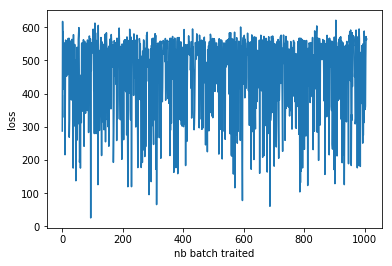

In [16]:
TRAIN_ITER = 1000
lossHisto = []
diffHisto = []
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = tweet()
    #print(t)
    
    x = Variable(toohot(torch.LongTensor(encode(t[:10]))))
    y = Variable(torch.LongTensor(encode(t[10:])))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    m.train(x, z, y)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [17]:
m.diffHisto[:200]

[('#', '\x11', 4.891098976135254),
 ('T', 'g', 9.647550582885742),
 ('e', 'g', 14.58665657043457),
 ('a', 'g', 19.34164047241211),
 ('m', 'g', 24.2723331451416),
 ('U', 'g', 29.184871673583984),
 ('S', 'g', 34.11042022705078),
 ('A', 'g', 38.996578216552734),
 ('\n', 'g', 43.92656707763672),
 ('#', 'g', 48.9360237121582),
 ('O', 'g', 53.70936965942383),
 ('p', 'g', 58.43160629272461),
 ('e', 'g', 63.37322235107422),
 ('n', 'g', 68.20592498779297),
 ('i', 'g', 73.07566833496094),
 ('n', 'g', 77.90837097167969),
 ('g', 'g', 82.52384948730469),
 ('C', 'g', 87.52252960205078),
 ('e', 'g', 92.46414184570312),
 ('r', 'g', 97.40729522705078),
 ('e', 'g', 102.34890747070312),
 ('m', 'g', 107.27954864501953),
 ('o', 'g', 112.11095428466797),
 ('n', 'g', 116.94365692138672),
 ('y', 'g', 121.7818603515625),
 (' ', 'g', 126.64897155761719),
 ('#', 'g', 131.65843200683594),
 ('R', 'g', 136.5967254638672),
 ('i', 'g', 141.46646118164062),
 ('o', 'g', 146.29786682128906),
 ('2', 'g', 151.136154174804

In [18]:
t = tweet()
tCut = t[:10]
te = Variable(toohot(torch.LongTensor(encode(tCut))), volatile = True)
z = Variable(torch.zeros(zLen).type(torch.FloatTensor), volatile = True)
r, z = m.predict(te, z)
print(t)
print(tCut)
print(tofint(r))
print(decode(tofint(r)))

Does President Obama ever discuss the sneak attack on Pearl Harbor while hes in Japan? Thousands of American lives lost. #MDW
Does Presi
Variable containing:
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
 32
[torch.LongTensor of size 101]

                                                                                                     


Bon ça ne marche tjs pas, on vas passer au lstm.

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(LSTM, self).__init__()        
        
        self.input_size  = input_size    # Vocabulaire
        self.hidden_size = hidden_size   # Mémoire
        
        self.forgetGate = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.inputGate  = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.writeGate  = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.readGate   = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.outputGate = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
    
    def forward(self, x, h, z):
        
        # Initial concatenation
        inp = torch.cat((x, h), 0)
        
        # Forget Gate
        z *= F.sigmoid(self.forgetGate(inp))
        
        # Write
        it = F.sigmoid(self.inputGate(inp))
        ct = F.tanh(self.writeGate(inp))
        z += ct * it
        
        # Read
        rc = F.tanh(z)
        ot = F.sigmoid(self.outputGate(inp))
        
        '''return h, z'''
        return rc*ot, z

In [31]:
class Seq2SeqLSTM(object):
    def __init__(self, recurIn, recurOut, stop, maxLen = 100, debug = False):
        super().__init__()
        self.recurIn = recurIn
        self.recurOut = recurOut
        self.stop = stop
        self.maxLen = maxLen
        self.debug = debug
        if self.debug :
            self.lossHisto = []
            self.diffHisto = []
    
    def predict(self, boot, h, z):
        for i in boot:
            h, z = self.recurIn(i, h, z)
        r = []
        cpt = 1
        x, h, z = self.recurOut(boot[-1], h, z)
        r.append(x)
        while tofint(x.data)[0] != tofint(self.stop)[0] and cpt <= self.maxLen:
            cpt +=1
            x, h, z = self.recurOut(x, h, z)
            r.append(x)
        
        r = torch.stack(r)
        return r, h, z
    
    def train(self, inputs, h, z, outputs):
        '''
            :param inputs: Input sequence
        '''
        loss = nn.CrossEntropyLoss()
        sgdIn  = optim.SGD(self.recurIn.parameters(), lr=1e-3)
        sgdOut  = optim.SGD(self.recurOut.parameters(), lr=1e-3)
        
        for i in inputs[:-1]:
            h, z = self.recurIn(i, h, z)
            
        r = inputs[-1]
        l = 0
        for i in outputs:
            r, h, z = self.recurOut(r, h, z)
            l += loss.forward(r.unsqueeze(0), i)
            if self.debug : self.diffHisto.append((decode(i), decode(tofint(r)), l.data.mean()))
            
        if self.debug : self.lossHisto.append(l.data.mean())        
        l.backward()   
        sgdIn.step()
        sgdOut.step()
        
        return z

In [11]:
class RecurentCont(nn.Module):
    def __init__(self, encoder, decoder):
        '''X et Y vecteur onehot de taille tailleVoc
        Z vecteur de stockage de taille tailleZ'''
        super(RecurentCont, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, h, z):
        '''return Y, h, Z'''
        h, z = self.encoder(x, h, z)
        return self.decoder(h), h, z

In [33]:
zLen = 500
hLen = 500
recurIn = LSTM(VOCAB_SIZE+1, hLen)
recurOut = RecurentCont(LSTM(VOCAB_SIZE+1, hLen), nn.Linear(hLen, VOCAB_SIZE+1))
m = Seq2SeqLSTM(recurIn, recurOut, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


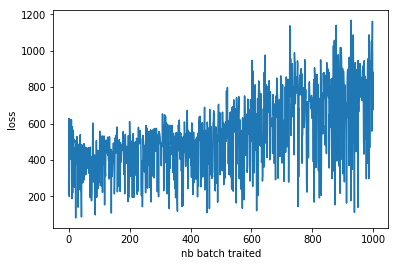

In [34]:
TRAIN_ITER = 1000
lossHisto = []
diffHisto = []
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = tweet()
    #print(t)
    
    x = Variable(toohot(torch.LongTensor(encode(t[:10]))))
    y = Variable(torch.LongTensor(encode(t[10:])))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    h = Variable(torch.zeros(hLen).type(torch.FloatTensor))
    m.train(x, h, z, y)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [40]:
m.diffHisto[-200:]

[('n', ' ', 126.03581237792969),
 ('d', ' ', 132.90689086914062),
 (' ', ' ', 134.313720703125),
 ('r', ' ', 146.1661376953125),
 ('a', ' ', 152.7766571044922),
 ('p', ' ', 158.62612915039062),
 ('i', ' ', 164.739990234375),
 ('d', ' ', 171.61105346679688),
 ('l', ' ', 193.66355895996094),
 ('y', ' ', 199.9951171875),
 (' ', ' ', 201.40194702148438),
 ('g', ' ', 207.47718811035156),
 ('e', ' ', 223.54457092285156),
 ('t', ' ', 226.20408630371094),
 ('t', ' ', 228.8636016845703),
 ('i', ' ', 234.9774627685547),
 ('n', ' ', 241.10812377929688),
 ('g', ' ', 247.18336486816406),
 (' ', ' ', 248.59019470214844),
 ('w', ' ', 256.7372741699219),
 ('o', ' ', 259.55413818359375),
 ('r', ' ', 271.40655517578125),
 ('s', ' ', 274.41278076171875),
 ('e', ' ', 290.48016357421875),
 ('.', ' ', 292.1497497558594),
 (' ', ' ', 293.55657958984375),
 ('L', ' ', 298.54937744140625),
 ('o', ' ', 301.3662414550781),
 ('o', ' ', 304.18310546875),
 ('k', ' ', 318.8200378417969),
 (' ', ' ', 320.2268676757812

In [38]:
t = tweet()
tCut = t[:10]
te = Variable(toohot(torch.LongTensor(encode(tCut))), volatile = True)
z = Variable(torch.zeros(zLen).type(torch.FloatTensor), volatile = True)
h = Variable(torch.zeros(hLen).type(torch.FloatTensor), volatile = True)
r, h, z = m.predict(te, h, z)
print(t)
print(tCut)
print(tofint(r))
print(decode(tofint(r)))

"@becker_berta: @longtalltexan20 Trump single handedly did what no other politician ever dared to do, attacked the media for all their lies"
"@becker_b
Variable containing:
 111
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
  32
[torch.LongTensor of size 101]

o                                                                                                    


In [33]:
class Seq2SeqLSTM(object):
    def __init__(self, recurIn, recurOut, stop, maxLen = 100, debug = False):
        super().__init__()
        self.recurIn = recurIn
        self.recurOut = recurOut
        self.stop = stop
        self.maxLen = maxLen
        self.debug = debug
        if self.debug :
            self.lossHisto = []
            self.diffHisto = []
    
    def predict(self, boot, h, z):
        for i in boot:
            h, z = self.recurIn(i, h, z)
        r = []
        cpt = 1
        x, h, z = self.recurOut(boot[-1], h, z)
        r.append(x)
        while tofint(x.data)[0] != tofint(self.stop)[0] and cpt <= self.maxLen:
            cpt +=1
            x, h, z = self.recurOut(x, h, z)
            r.append(x)
        
        r = torch.stack(r)
        return r, h, z
    
    def train(self, inputs, h, z, outputs, eps = 0.0005):
        '''
            :param inputs: Input sequence
        '''
        loss = nn.CrossEntropyLoss()
        sgdIn  = optim.SGD(self.recurIn.parameters(), lr=eps)
        sgdOut  = optim.SGD(self.recurOut.parameters(), lr=eps)
        
        for i in inputs[:-1]:
            h, z = self.recurIn(i, h, z)
            
        r = inputs[-1]
        l = 0
        for i in outputs:
            r, h, z = self.recurOut(r, h, z)
            l += loss.forward(r.unsqueeze(0), i)
            if self.debug : self.diffHisto.append((decode(i), decode(tofint(r)), l.data.mean()))
            
        if self.debug : self.lossHisto.append(l.data.mean())        
        l.backward()   
        sgdIn.step()
        sgdOut.step()
        
        return z

In [34]:
zLen = 500
hLen = 500
recurIn = LSTM(VOCAB_SIZE+1, hLen)
recurOut = RecurentCont(LSTM(VOCAB_SIZE+1, hLen), nn.Linear(hLen, VOCAB_SIZE+1))
m = Seq2SeqLSTM(recurIn, recurOut, toohot(torch.LongTensor([FINAL_CHAR])), debug = True)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


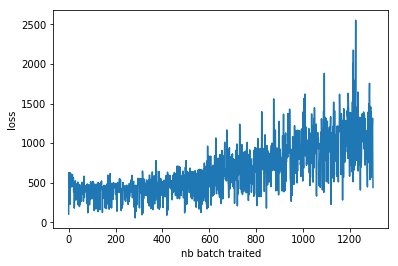

In [37]:
TRAIN_ITER = 1000
lossHisto = []
diffHisto = []
for i in range(TRAIN_ITER):
    
    if i%(TRAIN_ITER/10) == 0:
        print("Iteration", i)
    
    t = tweet()
    #print(t)
    
    x = Variable(toohot(torch.LongTensor(encode(t[:10]))))
    y = Variable(torch.LongTensor(encode(t[10:])))
    z = Variable(torch.zeros(zLen).type(torch.FloatTensor))
    h = Variable(torch.zeros(hLen).type(torch.FloatTensor))
    m.train(x, h, z, y, 0.0008)

plt.plot(m.lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

In [38]:
m.diffHisto[-200:]

[('e', 'e', 58.436405181884766),
 (' ', 'e', 63.733360290527344),
 ('v', 'e', 77.91210174560547),
 ('o', 'e', 89.45307922363281),
 ('t', 'e', 94.18793487548828),
 ('e', 'e', 95.86434173583984),
 ('r', 'e', 99.07795715332031),
 ('s', 'e', 104.98333740234375),
 (' ', 'e', 110.28030395507812),
 ('w', 'e', 138.85919189453125),
 ('i', 'e', 144.8513641357422),
 ('l', 'e', 148.1332550048828),
 ('l', 'e', 151.41514587402344),
 (' ', 'e', 156.7121124267578),
 ('f', 'e', 183.4110107421875),
 ('o', 'e', 194.95199584960938),
 ('r', 'e', 198.16561889648438),
 ('g', 'e', 234.52566528320312),
 ('e', 'e', 236.2020721435547),
 ('t', 'e', 240.93692016601562),
 (' ', 'e', 246.23388671875),
 ('t', 'e', 250.96875),
 ('h', 'e', 264.4108581542969),
 ('e', 'e', 266.0872802734375),
 (' ', 'e', 271.3842468261719),
 ('r', 'e', 274.5978698730469),
 ('i', 'e', 280.5900573730469),
 ('g', 'e', 316.9501037597656),
 ('g', 'e', 353.3101501464844),
 ('e', 'e', 354.986572265625),
 ('d', 'e', 357.1708068847656),
 (' ', 'e

In [20]:
t = tweet()
tCut = t[:10]
te = Variable(toohot(torch.LongTensor(encode(tCut))), volatile = True)
z = Variable(torch.zeros(zLen).type(torch.FloatTensor), volatile = True)
h = Variable(torch.zeros(hLen).type(torch.FloatTensor), volatile = True)
r, h, z = m.predict(te, h, z)
print(t)
print(tCut)
print(tofint(r))
print(decode(tofint(r)))

Big day in Texas tomorrow! Having a rally in Fort Worth. Tremendous crowd. Will be exciting! #Trump2016 https://t.co/JGUopujRIk
Big day in
Variable containing:
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
[torch.LongTensor of size 101]

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
